In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
from os import listdir
import seaborn as sns

plt.style.use('./fig.mplstyle')

In [2]:
resdir = '../experiments/results_exp_12_3e5/eval_results'

In [3]:
data = pd.concat([
    pd.read_parquet(join(resdir, f))
    for f in listdir(resdir)  
], ignore_index=True, axis=0)

/tmp/ipykernel_13756/591798307.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([


In [4]:
data.head()

Experiment id  Eval id   Eval seed  Cumulative reward Delay 0  Delay 1  \
0              2        0   137202697              569.0    None    -28.0   
1              6        0   242337748             -200.0    None      NaN   
2              5        0  1462673258               -2.0    None      NaN   
3              4        0  2867081385               -2.0    None      NaN   
4              1        0  2547741747             -123.0    None      NaN   

   Delay 2  Delay 3  Delay 4  # arrived  # arrived on time  
0    -20.0    -24.0    -28.0          4                  4  
1      NaN      NaN      NaN          0                  0  
2      NaN      NaN      NaN          0                  0  
3      NaN      NaN      NaN          0                  0  
4    -19.0      NaN      NaN          1                  1

In [15]:
data['Trains on time'] = (
    data[[c for c in data.columns if c.endswith('arrived')]].to_numpy().astype(bool) * \
    (data[[c for c in data.columns if c.endswith('delay')]].to_numpy() <= 0)
).mean(axis=1)

/tmp/ipykernel_15453/740427370.py:4: RuntimeWarning: Mean of empty slice.
  ).mean(axis=1)
/home/gianvito/Documents/Train-Rescheduling-Problem-with-RL/venv/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [16]:
data.head()

Experiment id  Eval id   Eval seed  Cumulative reward Delay 0 Delay 1  \
0              1        0  2547741747              303.0    None    None   

   Delay 2 Delay 3 Delay 4  # arrived  # arrived on time  Trains on time  
0    -23.0    None    None          1                  1             NaN

In [8]:
configs = pd.read_csv('./results_exp_12/1/1_config.csv')
configs.head()

Unnamed: 0              0
0        epsilon       1.000000
1  epsilon decay       0.999965
2          alpha       0.010000
3    alpha decay       1.000000
4     n_episodes  300000.000000

In [ ]:
data = pd.merge(data, configs, left_on='Experiment id', right_on='exp id')
data.columns

In [ ]:
data = data[[
    'Experiment id',
    'Episode',
    'Evaluation id',
    'Cumulative reward',
    'Flatland cumulative reward',
    'Flatland normalized reward',
    'Trains on time',
    '# malfunction steps',
    'Terminated by deadlock',
    'rate', 'min', 'max',
    'epsilon', 'epsilon decay',
    'alpha', 'alpha decay',
    'n_episodes'
]]
data.head()

In [8]:
data_last_episode = data[data['Episode'] == data['n_episodes']]
data_last_episode.head()

Experiment id  Episode  Evaluation id  Cumulative reward  \
871             27   400000              0              897.0   
872             27   400000              1              103.0   
873             27   400000              2              500.0   
874             27   400000              3              630.0   
875             27   400000              4             -754.0   

     Flatland cumulative reward  Flatland normalized reward  Trains on time  \
871                         0.0                         1.0             1.0   
872                         0.0                         1.0             0.2   
873                         0.0                         1.0             0.6   
874                         0.0                         1.0             0.4   
875                         0.0                         1.0             0.0   

     # malfunction steps  Terminated by deadlock   rate  min   max  epsilon  \
871                    0                   False  0.005  5.0  15.0      0.5   
872                   10                    True  0.005  5.0  15.0      0.5   
873                   42                   False  0.005  5.0  15.0      0.5   
874                   24                   False  0.005  5.0  15.0      0.5   
875                   22                    True  0.005  5.0  15.0      0.5   

     epsilon decay  alpha  alpha decay  n_episodes  
871       0.999975   0.01          1.0      400000  
872       0.999975   0.01          1.0      400000  
873       0.999975   0.01          1.0      400000  
874       0.999975   0.01          1.0      400000  
875       0.999975   0.01          1.0      400000

In [9]:
groups = data_last_episode.groupby(['rate', 'min', 'max', 'Experiment id'])
descr = lambda group_metric: \
    group_metric.sort_values(
        ['rate', 'min', 'max', 'Trains on time', 'Cumulative reward'], ascending=
        [True, True, True, False, False])\
    [['Trains on time', 'Cumulative reward', 'Flatland normalized reward', '# malfunction steps', 'Terminated by deadlock']]

mean = descr(groups.mean())
std = descr(groups.std())
# metrics = groups.mean()\
#     .sort_values(
#         ['rate', 'min', 'max', 'Trains on time', 'Cumulative reward'], ascending=
#         [True, True, True, False, False])\
#     [['Trains on time', 'Cumulative reward', 'Flatland normalized reward', '# malfunction steps', 'Terminated by deadlock']]

# Best performances

In [10]:
extract_best = lambda df: df[df['Experiment id'].isin([29, 14, 35, 16])]
best = extract_best(mean.reset_index())
best.drop(columns='Flatland normalized reward')

rate   min   max  Experiment id  Trains on time  Cumulative reward  \
0   0.001   5.0  15.0             29        0.968317         875.613861   
10  0.001  15.0  30.0             14        0.936634         855.821782   
20  0.005   5.0  15.0             35        0.638095         516.095238   
30  0.005  15.0  30.0             16        0.190476          30.523810   

    # malfunction steps  Terminated by deadlock  
0              2.386139                0.009901  
10             3.762376                0.029703  
20            15.380952                0.190476  
30            17.619048                0.761905

### Evaluation plots

Performance against malfunction time


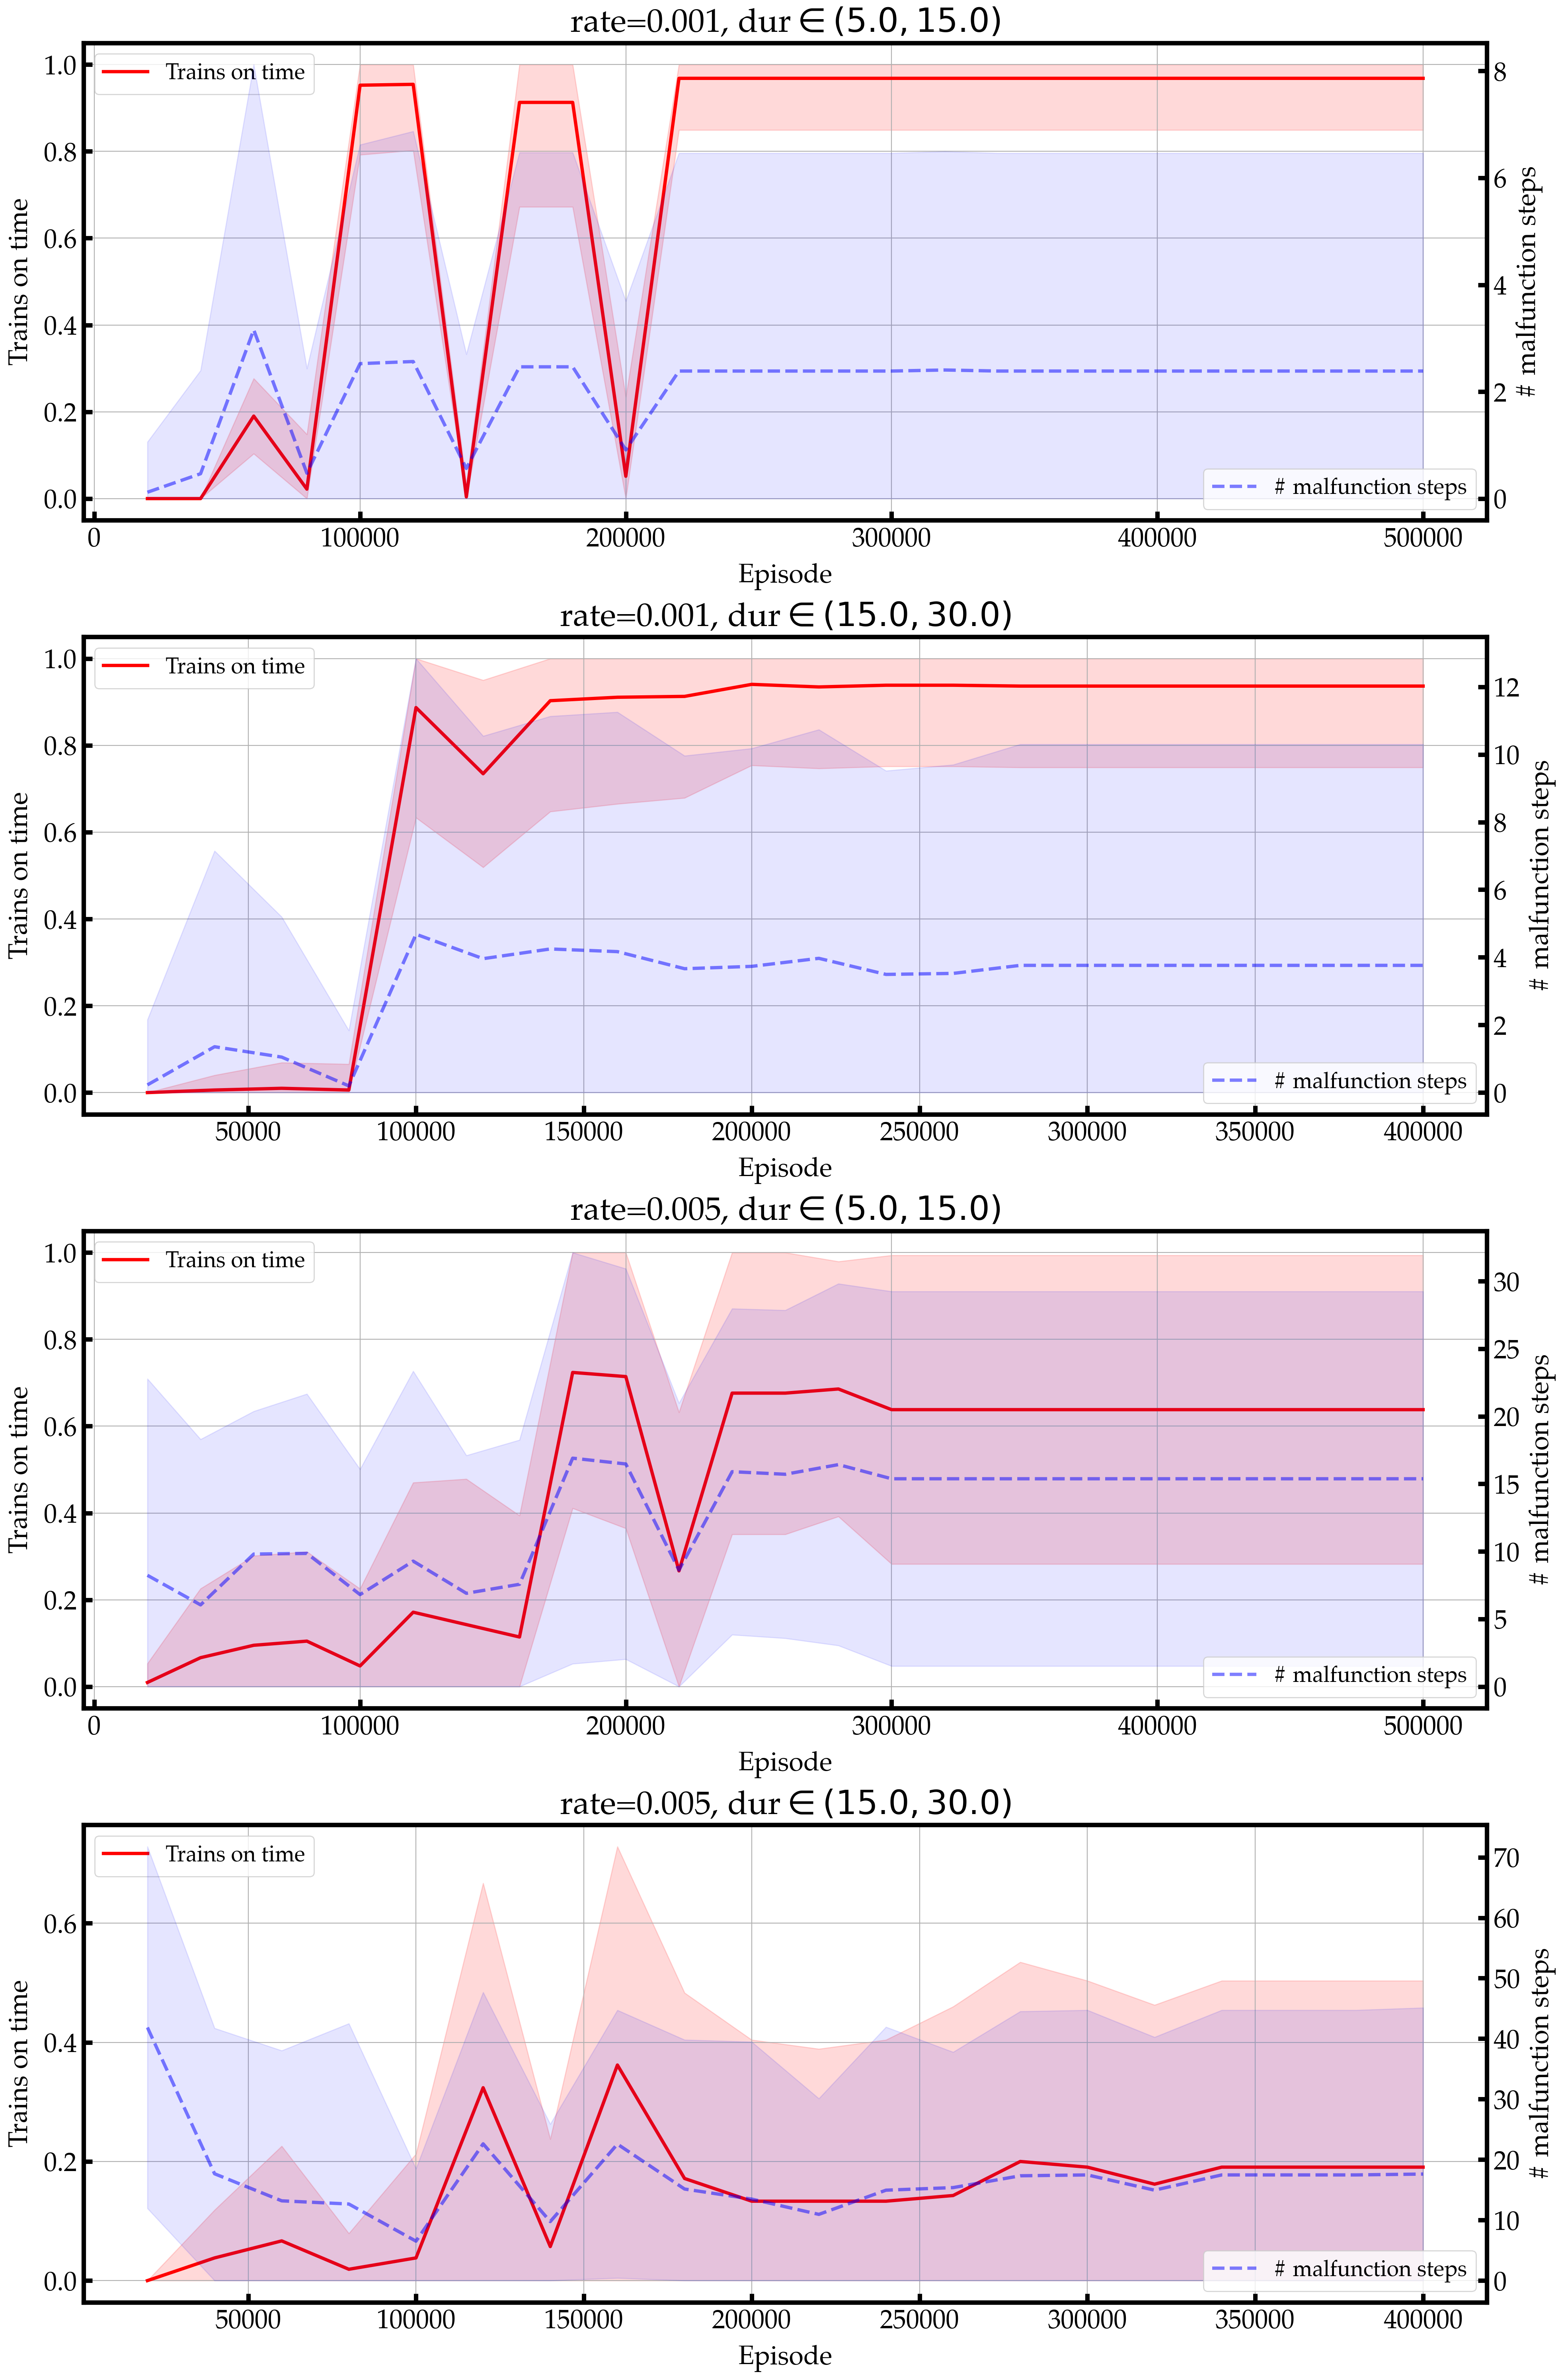

In [11]:
data_eval_best = data[data['Experiment id'].isin([29, 14, 35, 16])]
fig, axes = plt.subplots(4, 1, figsize=(20, 30))
for i, (label, group) in enumerate(data_eval_best.groupby(['rate', 'min', 'max'])):
    # Title
    title = f'rate={label[0]}, dur$\in({label[1]}, {label[2]})$'
    axes[i].set_title(title)
    
    grp = group.sort_values('Episode').groupby('Episode')
    mean = grp.mean()
    std = grp.std()
    max = grp.max()
    min = grp.min()

    x = mean.index

    cum_r = mean['Cumulative reward']
    cum_r_std = std['Cumulative reward']

    tot = mean['Trains on time']
    tot_std = std['Trains on time']

    malf_steps = mean['# malfunction steps']
    malf_steps_std = std['# malfunction steps']


    # Plot
    axes[i].plot(x, tot, label='Trains on time', color='red')
    axes[i].fill_between(x, np.clip(tot - tot_std, 0, 1), np.clip(tot + tot_std, 0, 1), alpha=0.15, color='red')

    twin = axes[i].twinx()
    twin.plot(x, malf_steps, label='# malfunction steps', color='blue', linestyle='--', alpha=0.5)
    twin.fill_between(x, np.clip(malf_steps - malf_steps_std, 0, None), malf_steps + malf_steps_std, alpha=0.10, color='blue')

    # Labels
    axes[i].set_ylabel('Trains on time')
    twin.set_ylabel('# malfunction steps')
    axes[i].set_xlabel('Episode')

    # Legend
    axes[i].legend(loc='upper left')
    twin.legend(loc='lower right')

    # Grid
    axes[i].grid()

print('Performance against malfunction time')
plt.tight_layout()
plt.savefig('figs/00_tot-nmalfs.png', dpi=300)
plt.show()

In [12]:
data_eval_best = data[data['Experiment id'].isin([29, 14, 35, 16])]
data_eval_best = data_eval_best[data_eval_best['Episode'] <= 400000]

Performance against deadlocks


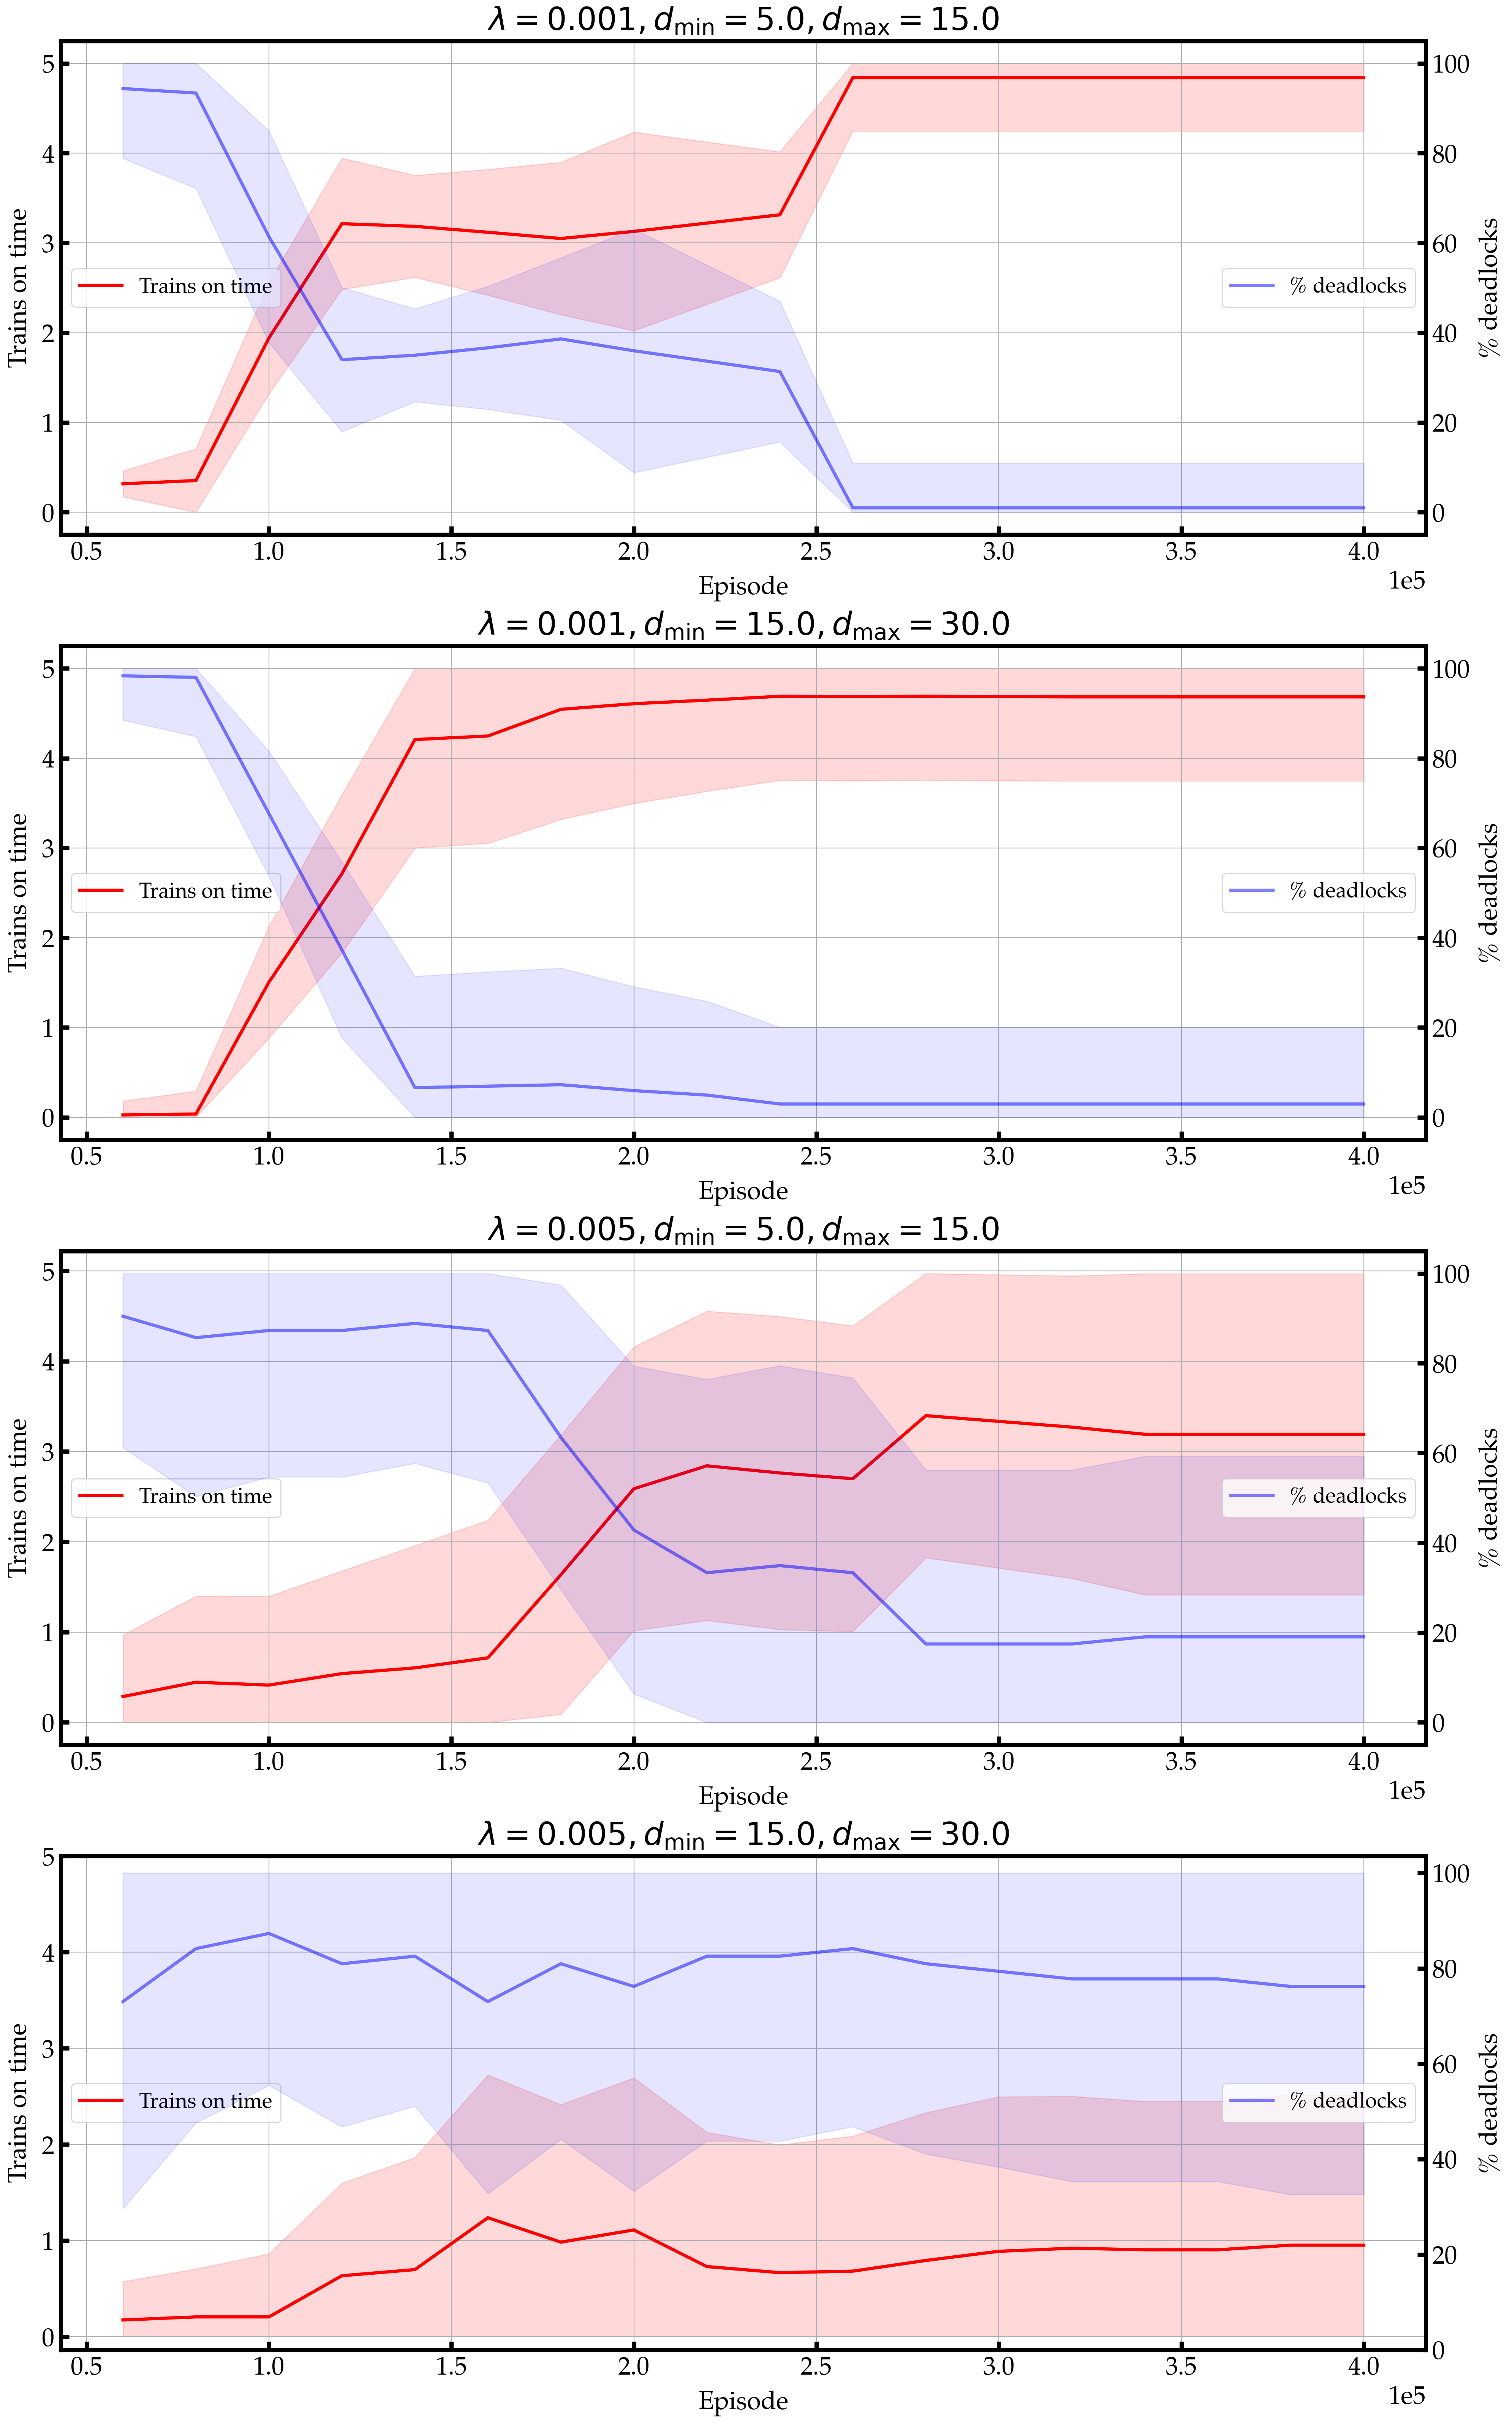

In [13]:
fig, axes = plt.subplots(4, 1, figsize=(20, 32))
window = 3
for i, (label, group) in enumerate(data_eval_best.groupby(['rate', 'min', 'max', 'Experiment id'])):
    # Title
    title = f'$\lambda={label[0]}, d_' + r'\text{min}' + f'={label[1]}, d_' + r'\text{max}' + f'={label[2]}$' #+f'\nExperiment {label[3]}'
    axes[i].set_title(title)
    
    grp = group.sort_values('Episode').groupby('Episode')
    mean = grp.mean().rolling(window=window).mean()
    std = grp.std().rolling(window=window).mean()
    max = grp.max()
    min = grp.min()

    x = mean.index

    cum_r = mean['Cumulative reward']
    cum_r_std = std['Cumulative reward']

    tot = mean['Trains on time']
    tot_std = std['Trains on time']

    malf_steps = mean['Terminated by deadlock'] * 100
    malf_steps_std = std['Terminated by deadlock'] * 100


    # Plot
    axes[i].plot(x, 5 * tot, label='Trains on time', color='red')
    axes[i].fill_between(x, 5 * np.clip(tot - tot_std, 0, 1), 5 * np.clip(tot + tot_std, 0, 1), alpha=0.15, color='red')

    twin = axes[i].twinx()
    twin.plot(x, malf_steps, label=r'% deadlocks', color='blue', linestyle='-', alpha=0.5)
    twin.fill_between(x, np.clip(malf_steps - malf_steps_std, 0, 100), np.clip(malf_steps + malf_steps_std, 0, 100), alpha=0.10, color='blue')

    # Labels
    axes[i].set_ylabel('Trains on time')
    twin.set_ylabel(r'% deadlocks')
    axes[i].set_xlabel('Episode')

    # Legend
    axes[i].legend(loc='center left')
    twin.legend(loc='center right')

    # Scientific notation
    axes[i].ticklabel_format(axis='x', style='sci', scilimits=(0,0))

    axes[i].set_yticks([0, 1, 2, 3, 4, 5])
    twin.set_yticks([0, 20, 40, 60, 80, 100])
    
    # Grid
    axes[i].grid()


print('Performance against deadlocks')
plt.tight_layout()
plt.savefig('figs/01_tot-deadlocks.png', dpi=300)
plt.show()

Performance against deadlocks


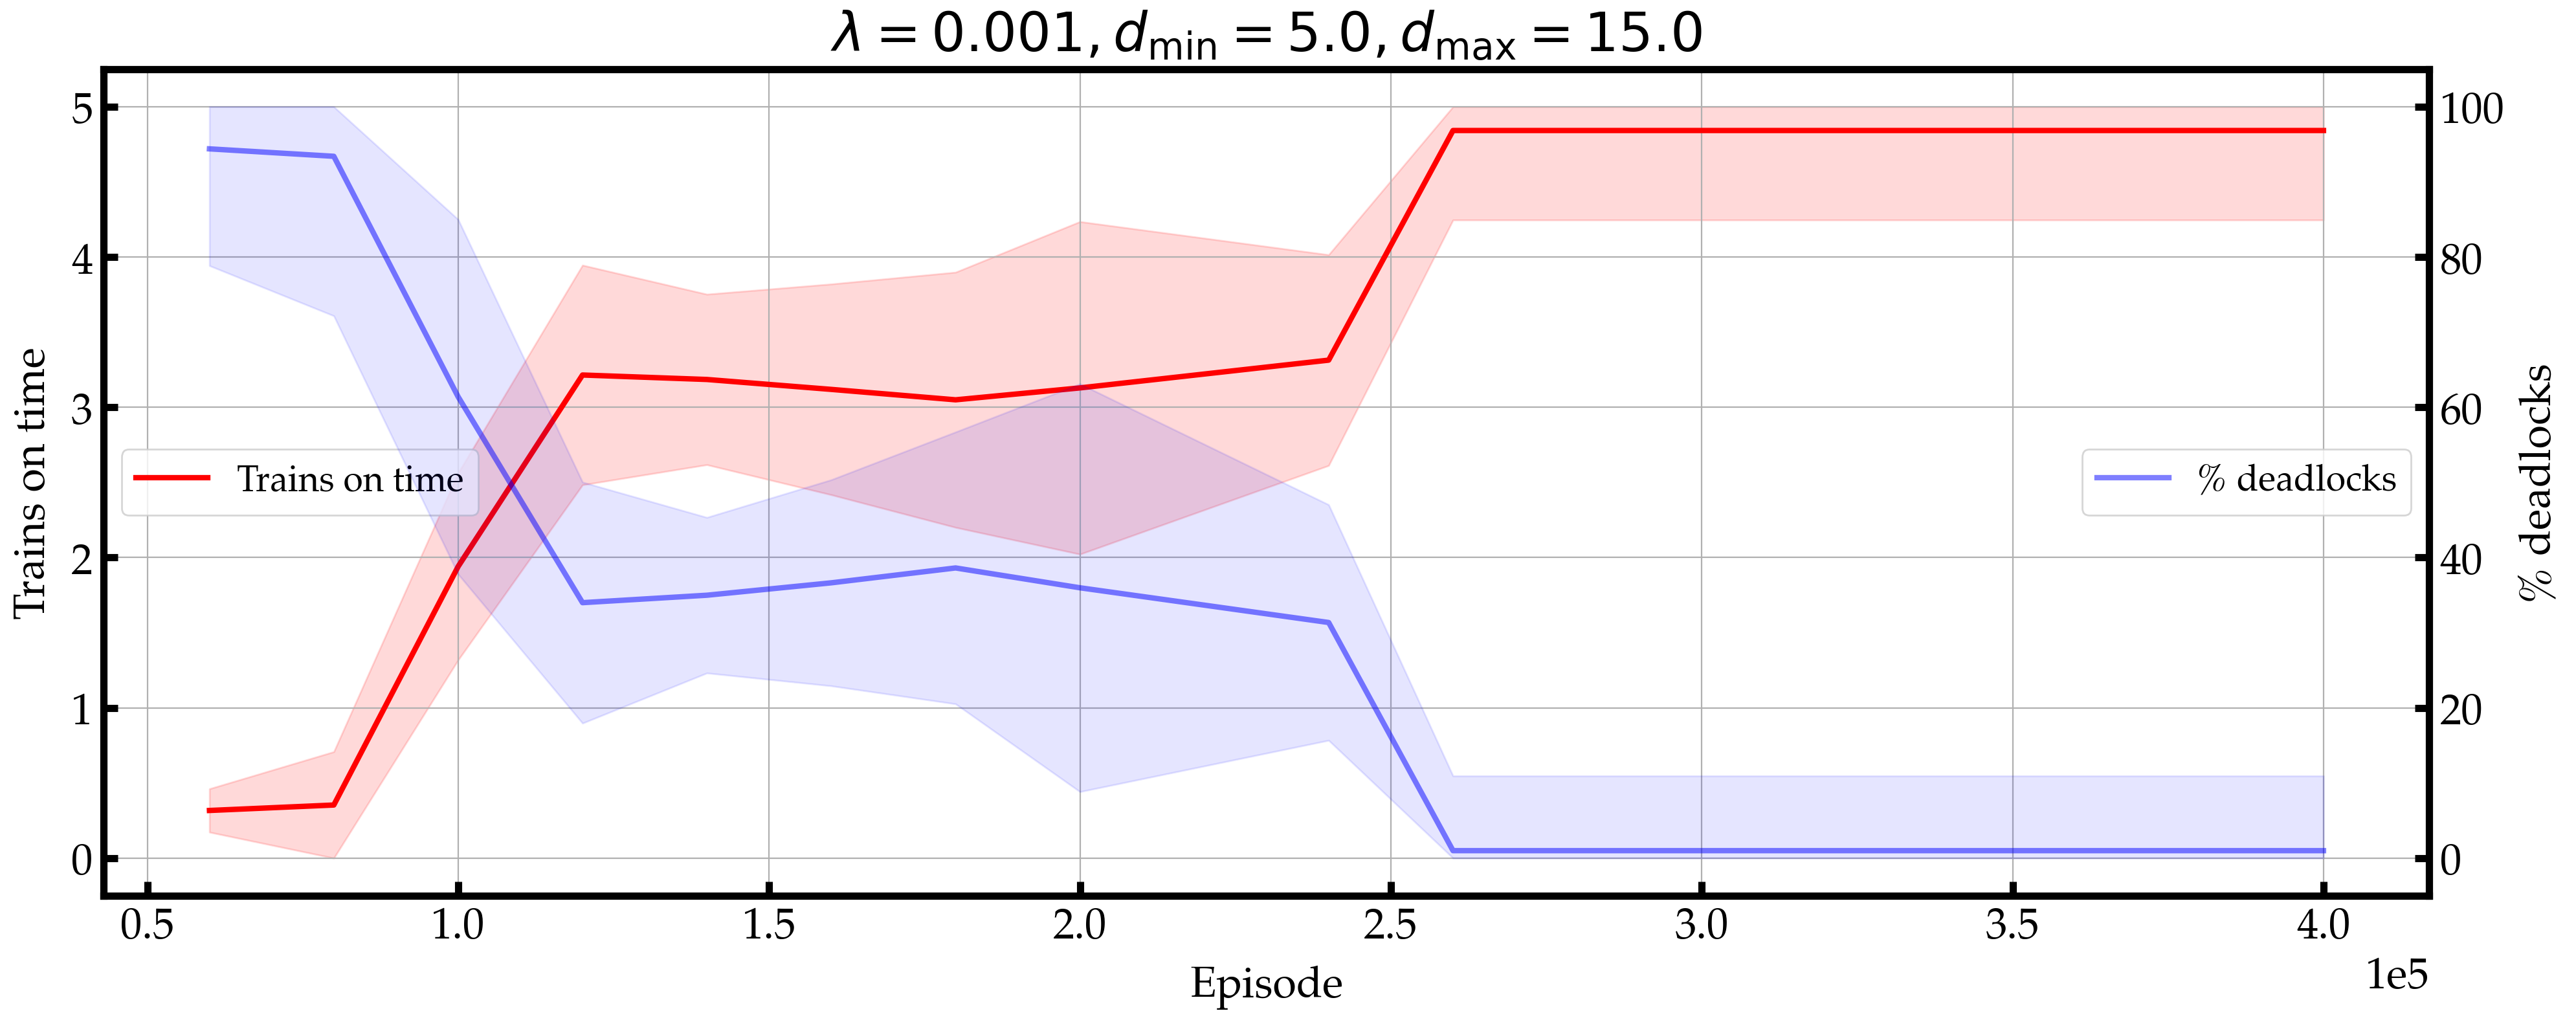

Performance against deadlocks


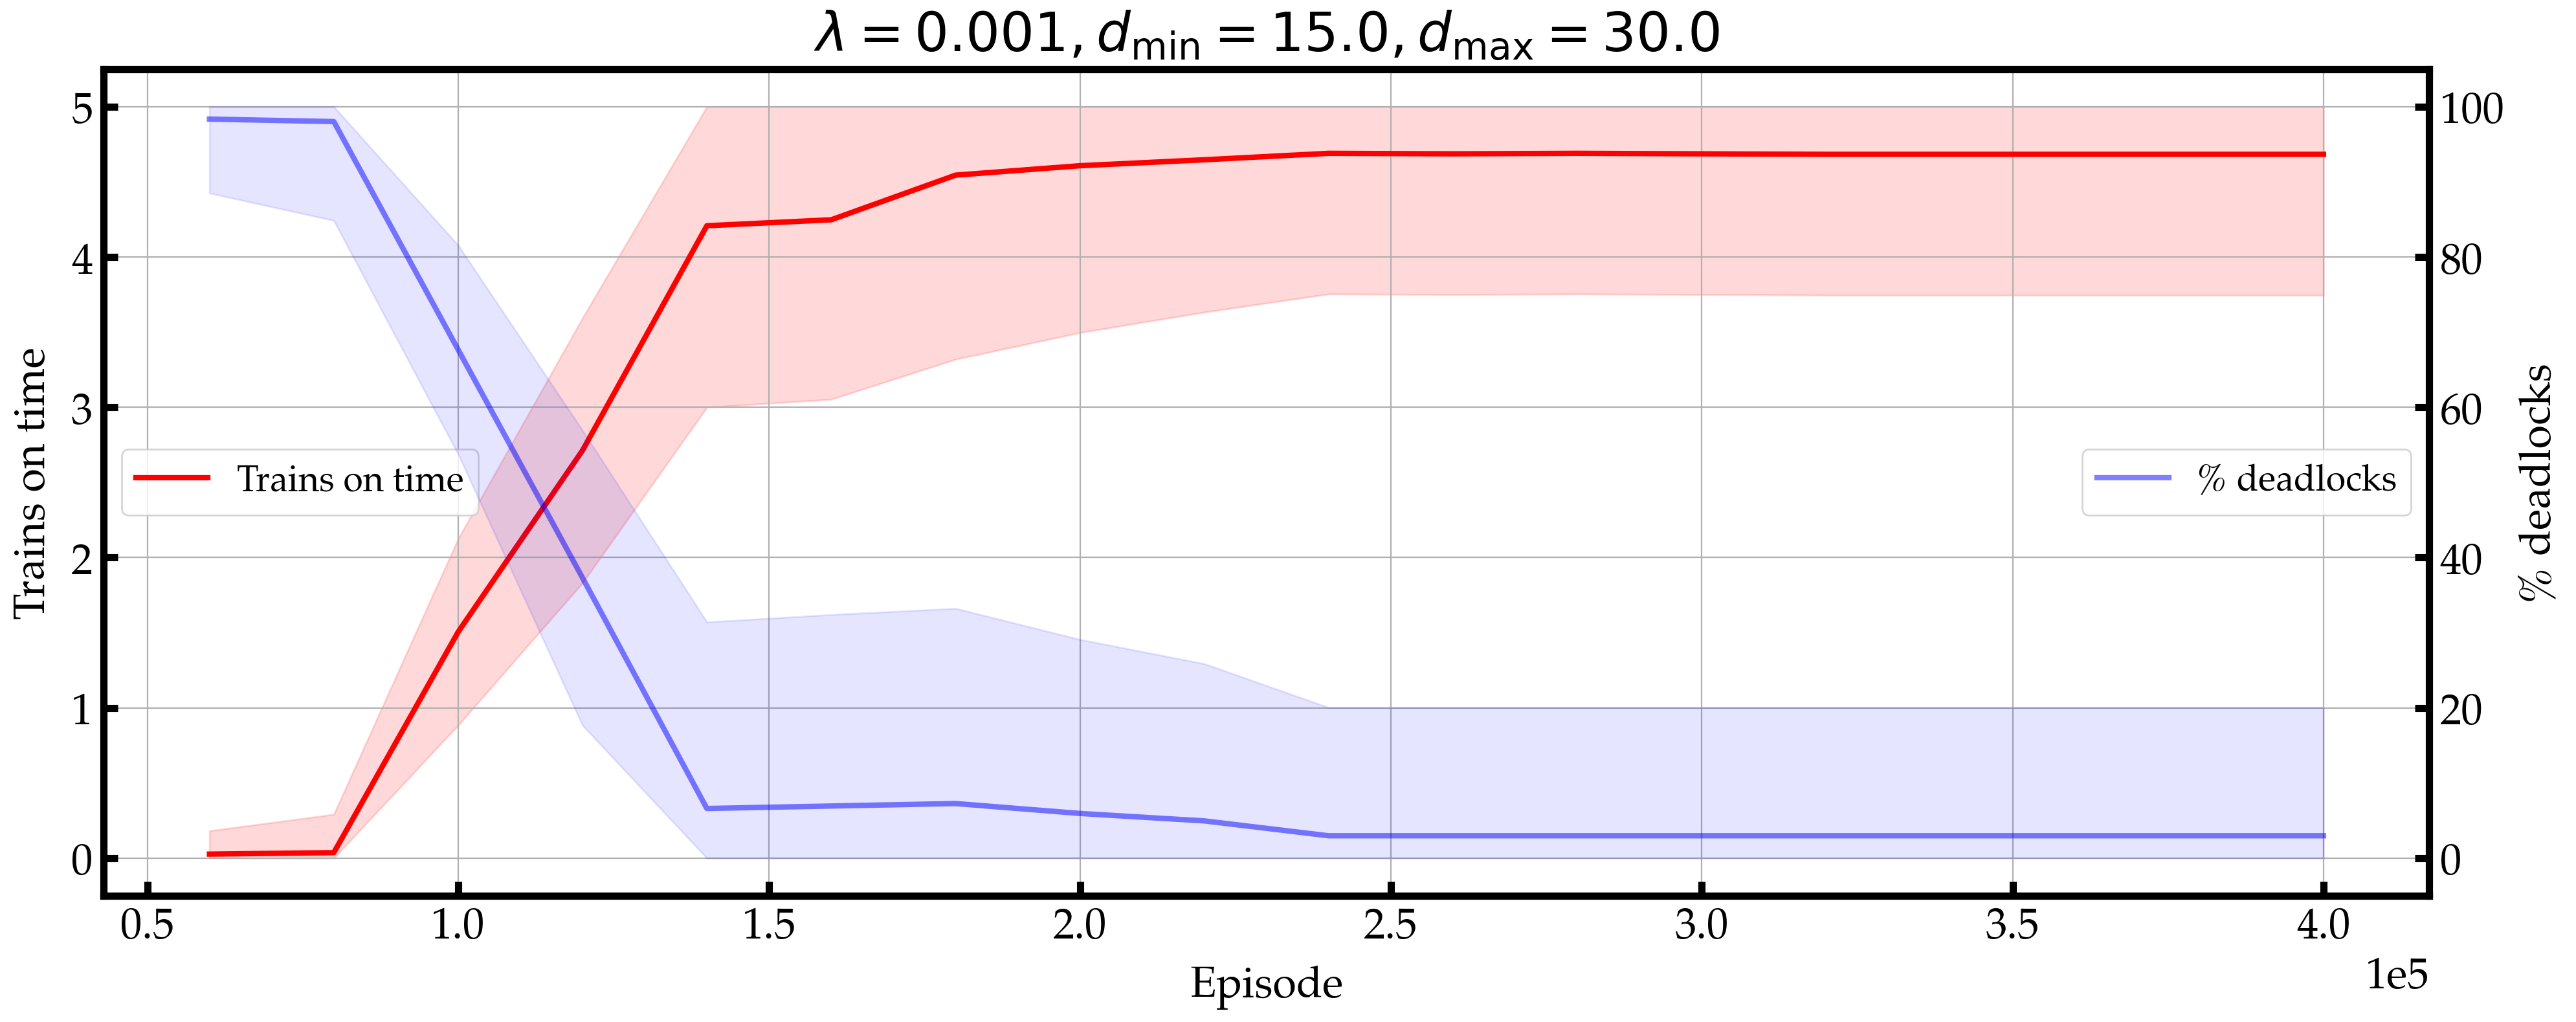

Performance against deadlocks


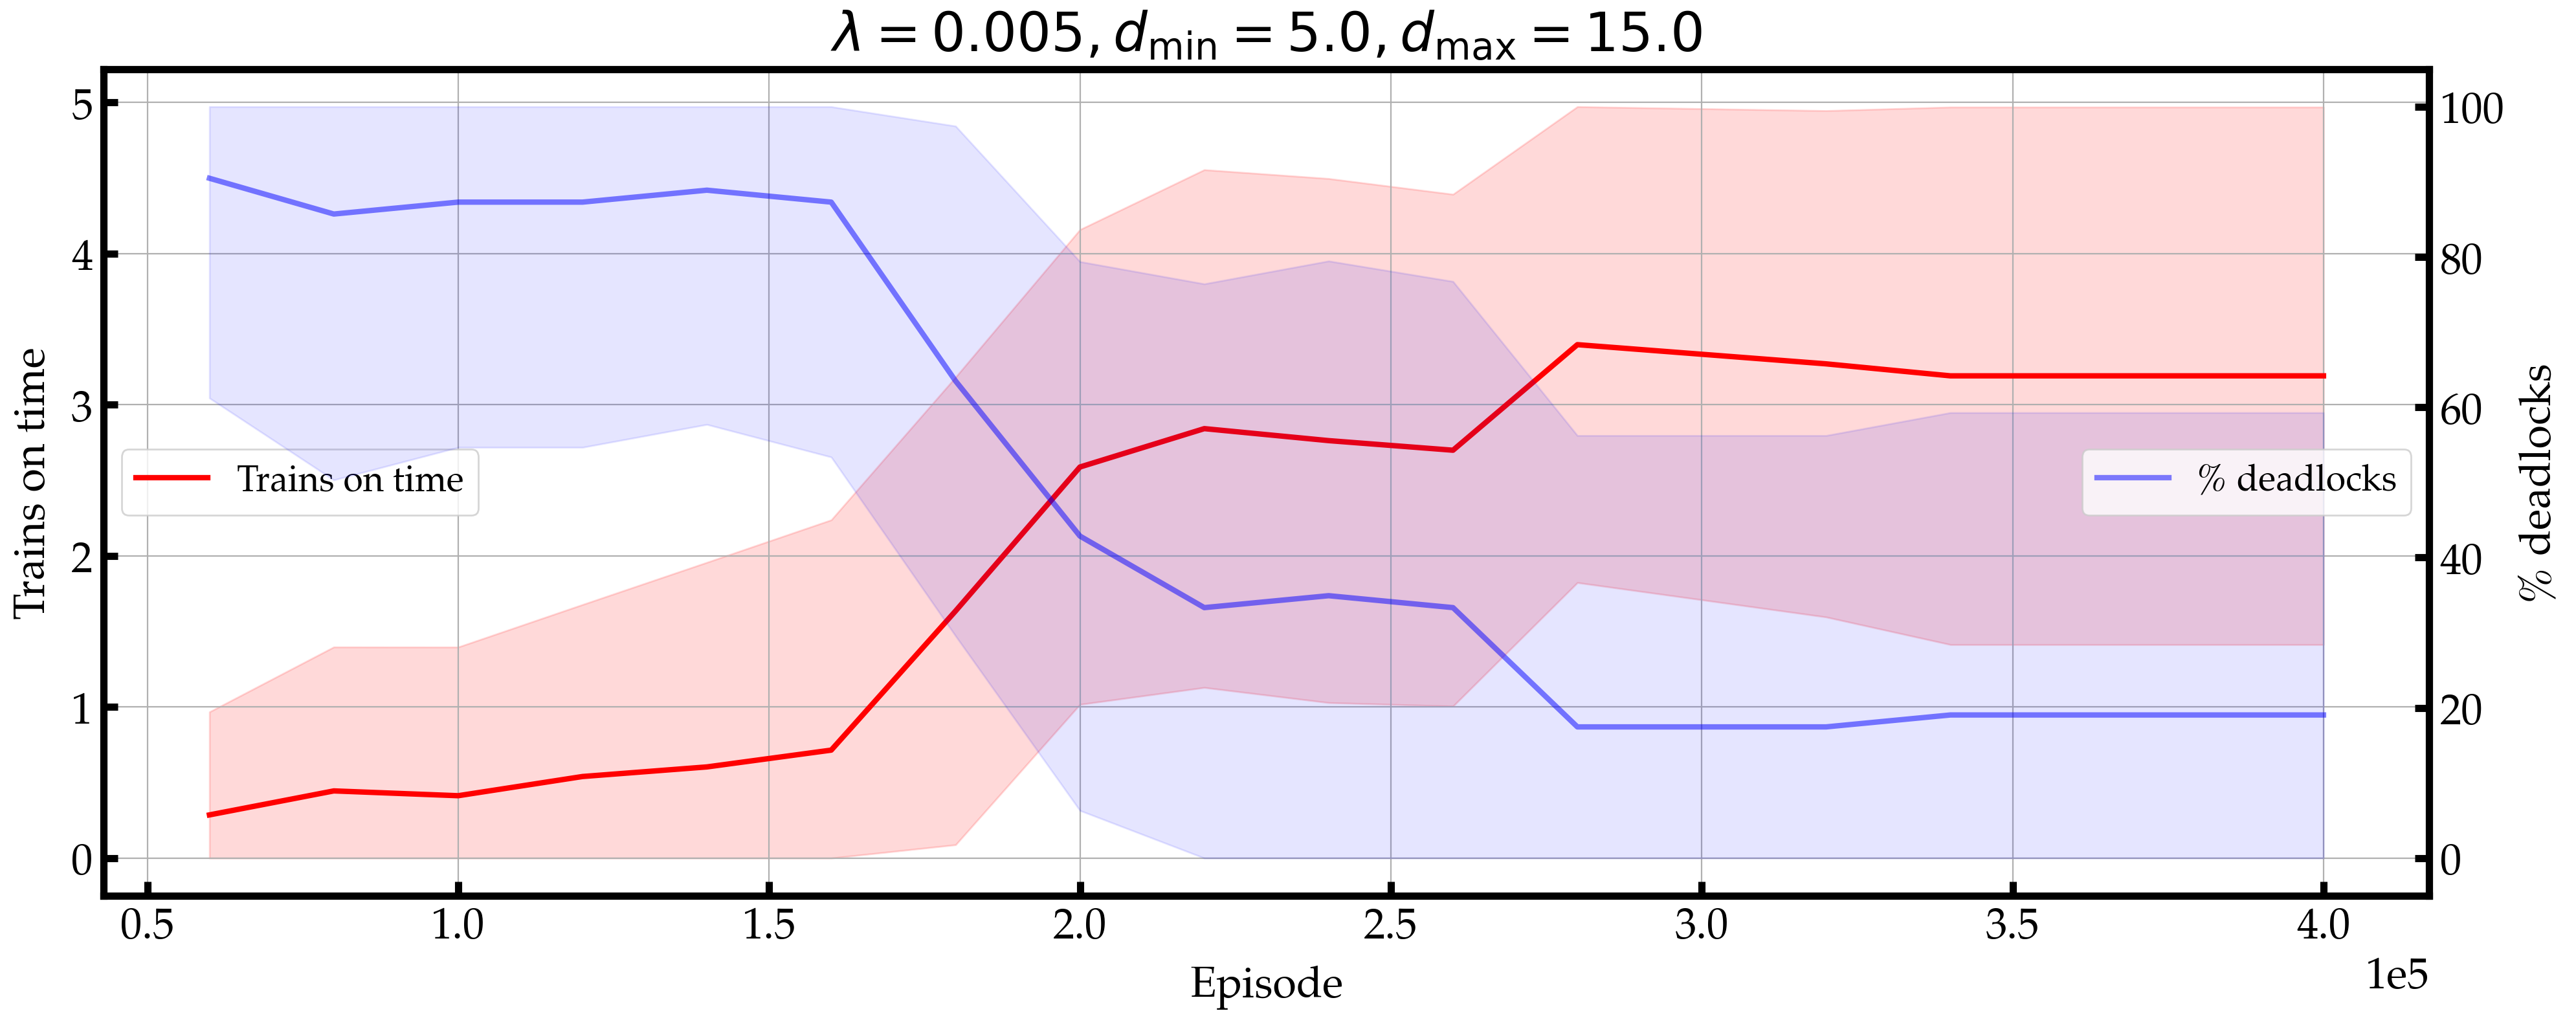

Performance against deadlocks


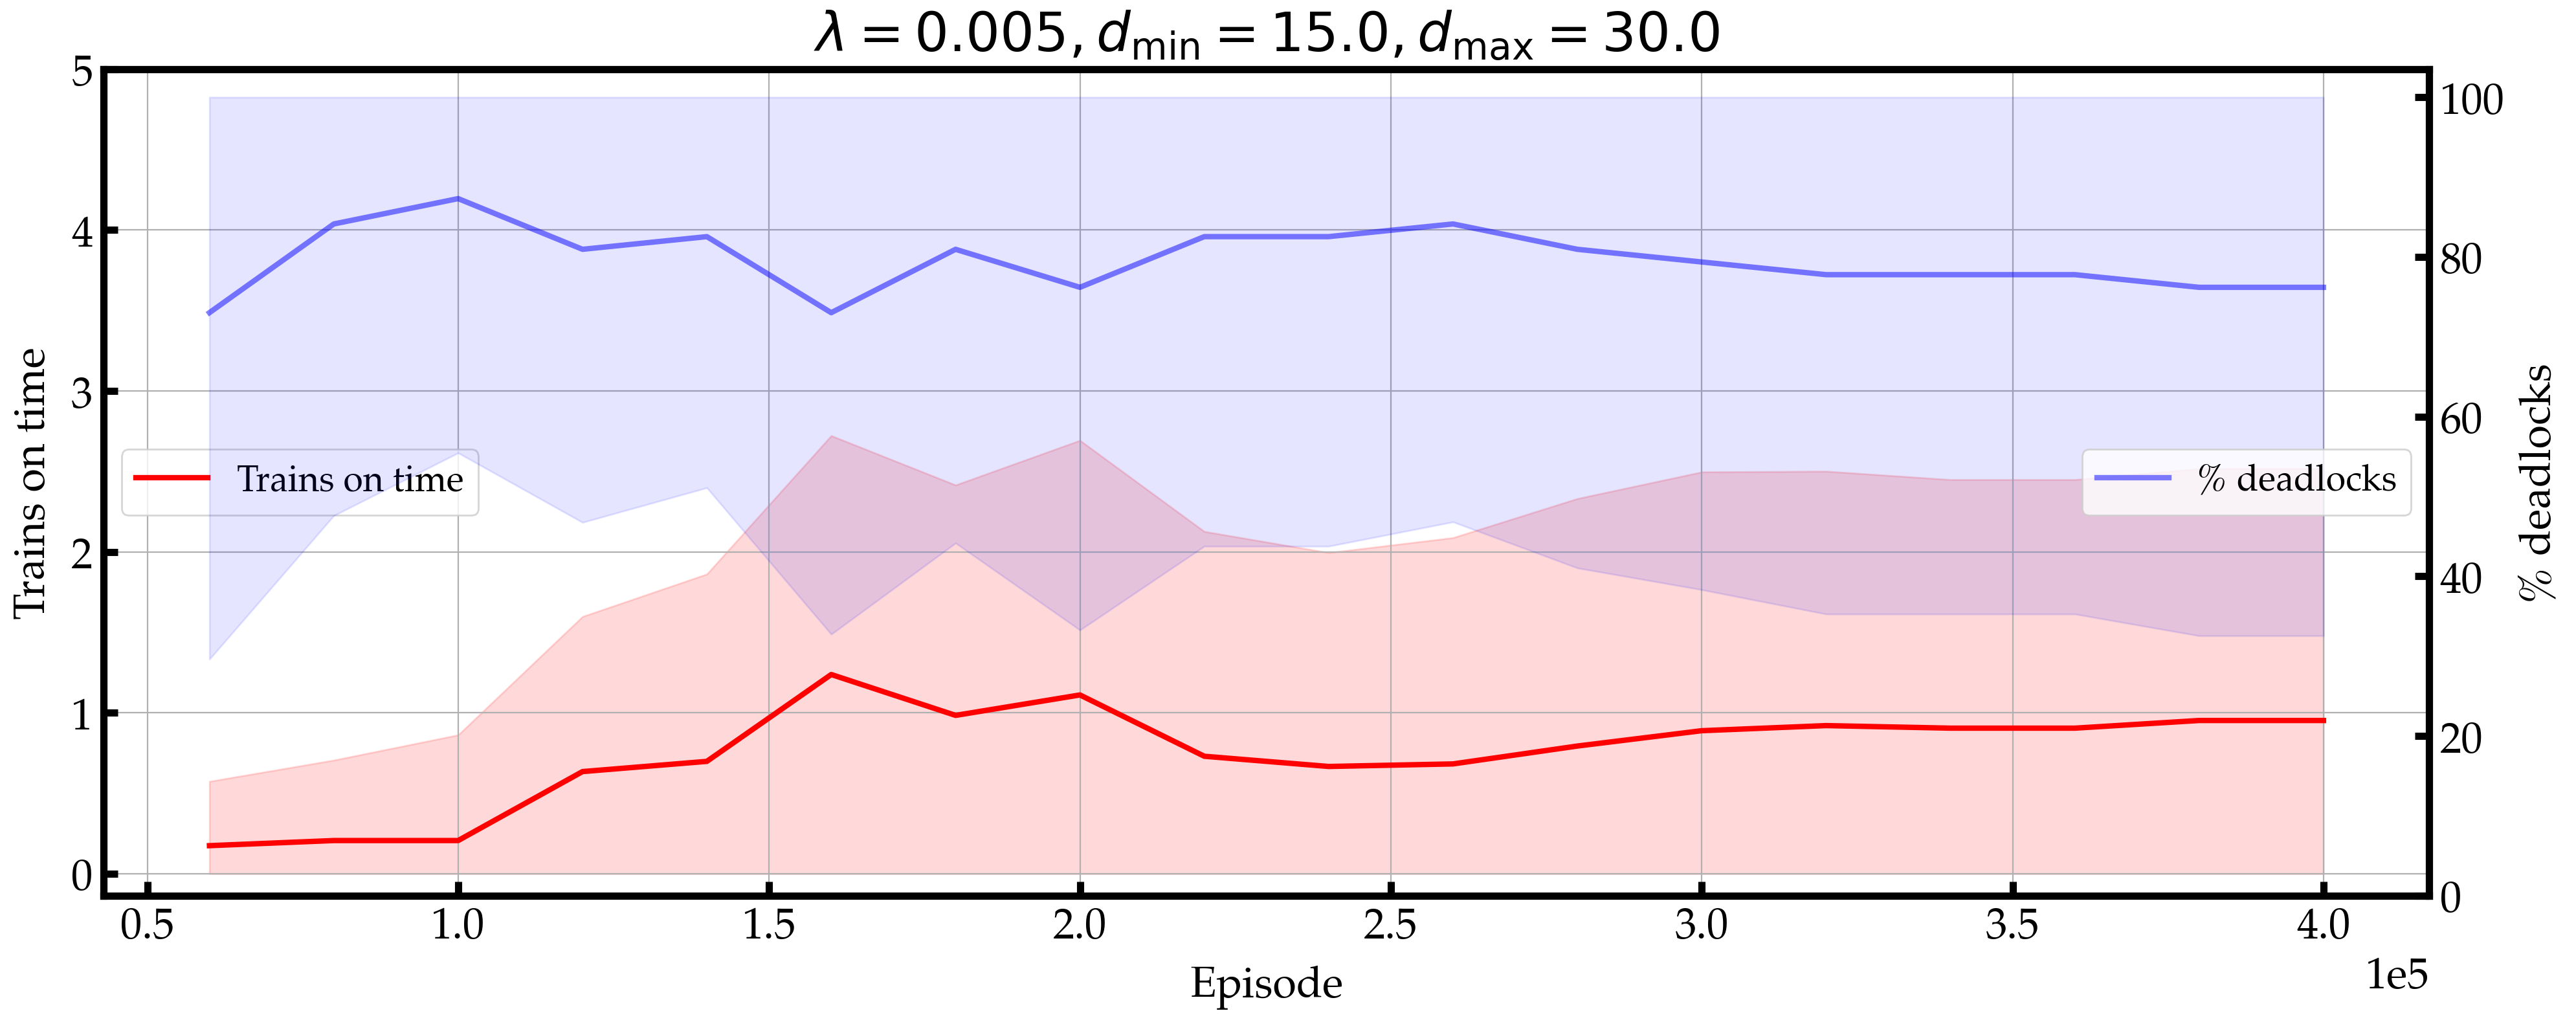

In [16]:
for j in range(4):
    fig, axes = plt.subplots(1, 1, figsize=(20, 8))
    window = 3
    for i, (label, group) in enumerate(data_eval_best.groupby(['rate', 'min', 'max', 'Experiment id'])):
        if i != j:
            continue
        # Title
        title = f'$\lambda={label[0]}, d_' + r'\text{min}' + f'={label[1]}, d_' + r'\text{max}' + f'={label[2]}$' #+f'\nExperiment {label[3]}'
        axes.set_title(title)
        
        grp = group.sort_values('Episode').groupby('Episode')
        mean = grp.mean().rolling(window=window).mean()
        std = grp.std().rolling(window=window).mean()
        max = grp.max()
        min = grp.min()

        x = mean.index

        cum_r = mean['Cumulative reward']
        cum_r_std = std['Cumulative reward']

        tot = mean['Trains on time']
        tot_std = std['Trains on time']

        malf_steps = mean['Terminated by deadlock'] * 100
        malf_steps_std = std['Terminated by deadlock'] * 100


        # Plot
        axes.plot(x, 5 * tot, label='Trains on time', color='red')
        axes.fill_between(x, 5 * np.clip(tot - tot_std, 0, 1), 5 * np.clip(tot + tot_std, 0, 1), alpha=0.15, color='red')

        twin = axes.twinx()
        twin.plot(x, malf_steps, label=r'% deadlocks', color='blue', linestyle='-', alpha=0.5)
        twin.fill_between(x, np.clip(malf_steps - malf_steps_std, 0, 100), np.clip(malf_steps + malf_steps_std, 0, 100), alpha=0.10, color='blue')

        # Labels
        axes.set_ylabel('Trains on time')
        twin.set_ylabel(r'% deadlocks')
        axes.set_xlabel('Episode')

        # Legend
        axes.legend(loc='center left')
        twin.legend(loc='center right')

        # Scientific notation
        axes.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

        axes.set_yticks([0, 1, 2, 3, 4, 5])
        twin.set_yticks([0, 20, 40, 60, 80, 100])
        
        # Grid
        axes.grid()


    print('Performance against deadlocks')
    plt.tight_layout()
    plt.savefig(f'figs/01_tot-deadlocks-v2-{j}.png', dpi=300)
    plt.show()

### Analizing performance on runs without deadlocks

In [ ]:
data_eval_nodd = data_eval_best[~data_eval_best['Terminated by deadlock']]
data_eval_nodd

Experiment id  Episode  Evaluation id  Cumulative reward  \
1302              16   360000              6              844.0   
1306              16   360000             10             -410.0   
1308              16   360000             12              130.0   
1312              16   360000             16              980.0   
1314              16   360000             18              967.0   
...              ...      ...            ...                ...   
50469             35   420000             20             -783.0   
50501             35    20000             10             -450.0   
51898             16   260000              6              794.0   
51902             16   260000             10             -410.0   
51910             16   260000             18              726.0   

       Flatland cumulative reward  Flatland normalized reward  Trains on time  \
1302                          0.0                    1.000000             1.0   
1306                        -57.0                    0.915556             0.6   
1308                          0.0                    1.000000             0.4   
1312                        -26.0                    0.961481             0.6   
1314                         -1.0                    0.998519             0.8   
...                           ...                         ...             ...   
50469                         0.0                    1.000000             0.4   
50501                      -144.0                    0.786667             0.0   
51898                         0.0                    1.000000             1.0   
51902                       -57.0                    0.915556             0.6   
51910                         0.0                    1.000000             1.0   

       # malfunction steps  Terminated by deadlock   rate   min   max  \
1302                     0                   False  0.005  15.0  30.0   
1306                    62                   False  0.005  15.0  30.0   
1308                    94                   False  0.005  15.0  30.0   
1312                    18                   False  0.005  15.0  30.0   
1314                    31                   False  0.005  15.0  30.0   
...                    ...                     ...    ...   ...   ...   
50469                   47                   False  0.005   5.0  15.0   
50501                   31                   False  0.005   5.0  15.0   
51898                    0                   False  0.005  15.0  30.0   
51902                   62                   False  0.005  15.0  30.0   
51910                   44                   False  0.005  15.0  30.0   

       epsilon  epsilon decay  alpha  alpha decay  n_episodes  
1302       1.0       0.999975    0.1      0.99999      400000  
1306       1.0       0.999975    0.1      0.99999      400000  
1308       1.0       0.999975    0.1      0.99999      400000  
1312       1.0       0.999975    0.1      0.99999      400000  
1314       1.0       0.999975    0.1      0.99999      400000  
...        ...            ...    ...          ...         ...  
50469      0.5       0.999980    0.1      0.99999      500000  
50501      0.5       0.999980    0.1      0.99999      500000  
51898      1.0       0.999975    0.1      0.99999      400000  
51902      1.0       0.999975    0.1      0.99999      400000  
51910      1.0       0.999975    0.1      0.99999      400000  

[3854 rows x 17 columns]

Performance against malfunction time in non-deadlock runs


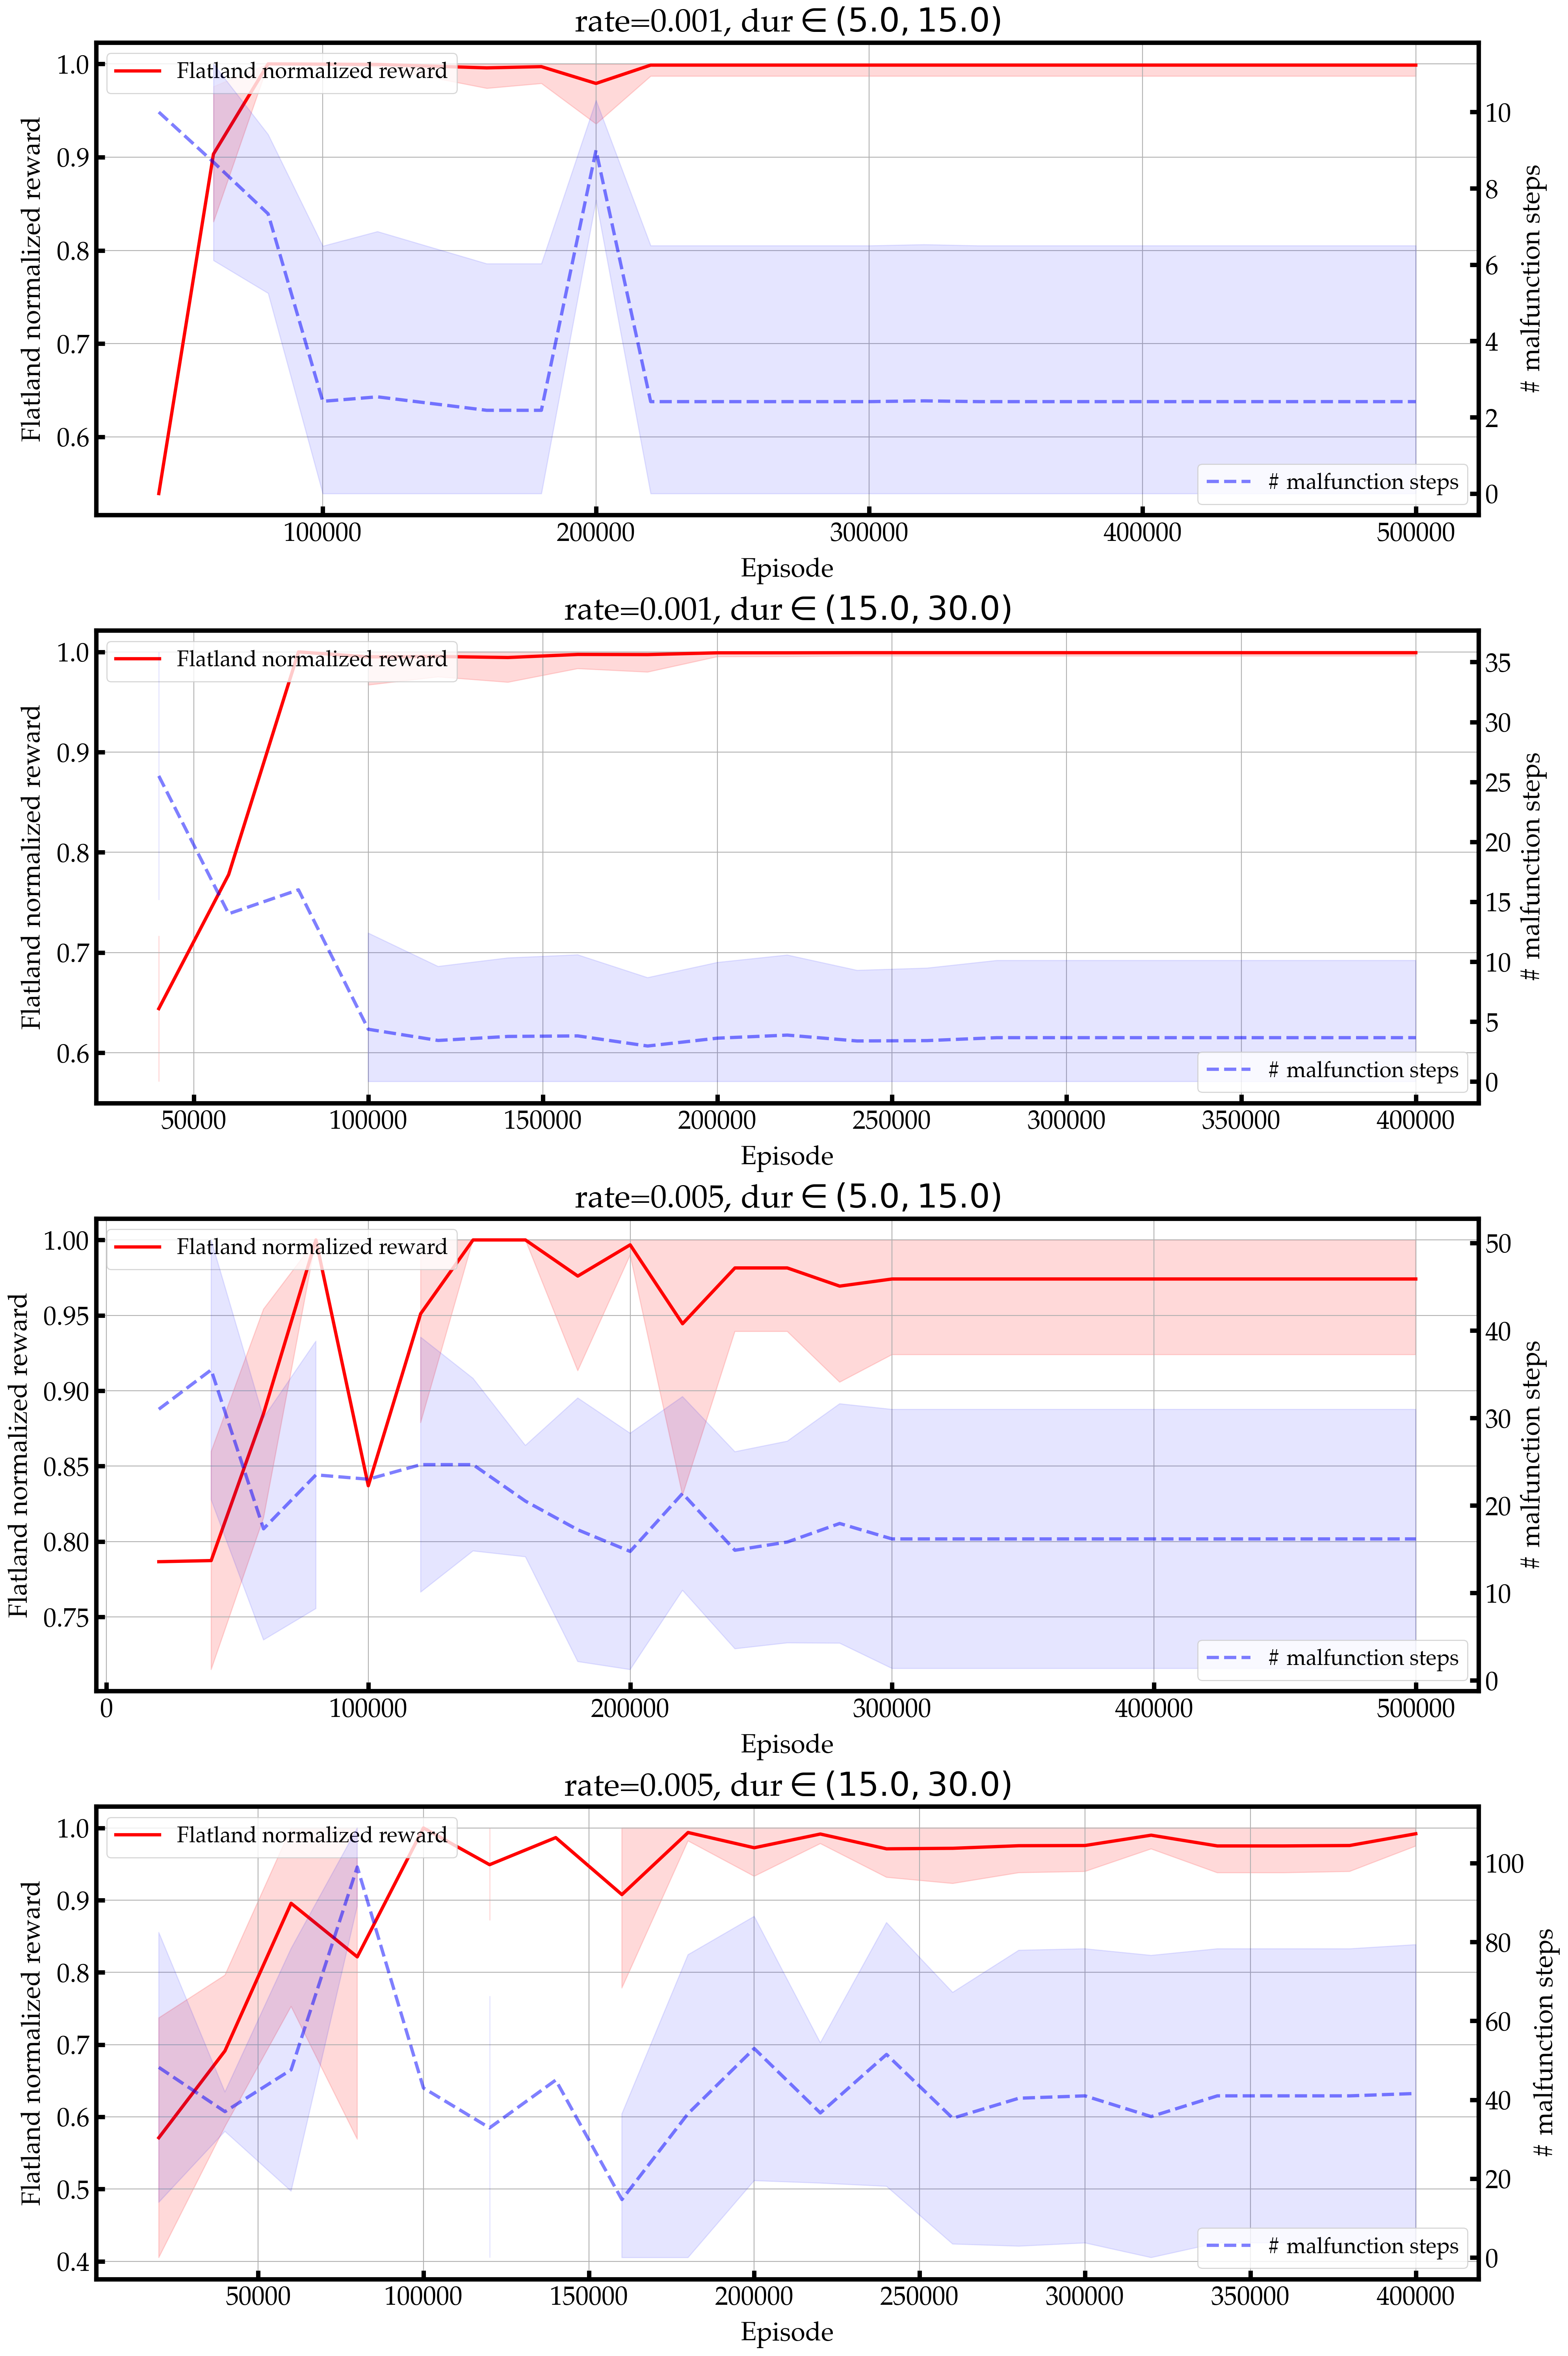

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(20, 30))
for i, (label, group) in enumerate(data_eval_nodd.groupby(['rate', 'min', 'max'])):    
    grp = group.sort_values('Episode').groupby('Episode')
    count = grp.count()
    mean = grp.mean()
    std = grp.std()
    max = grp.max()
    min = grp.min()

    title = f'rate={label[0]}, dur$\in({label[1]}, {label[2]})$'
    axes[i].set_title(title)

    x = mean.index

    cum_r = mean['Cumulative reward']
    cum_r_std = std['Cumulative reward']

    tot = mean['Flatland normalized reward']
    tot_std = std['Flatland normalized reward']

    malf_steps = mean['# malfunction steps']
    malf_steps_std = std['# malfunction steps']


    # Plot
    axes[i].plot(x, tot, label='Flatland normalized reward', color='red')
    axes[i].fill_between(x, np.clip(tot - tot_std, 0, 1), np.clip(tot + tot_std, 0, 1), alpha=0.15, color='red')

    twin = axes[i].twinx()
    twin.plot(x, malf_steps, label='# malfunction steps', color='blue', linestyle='--', alpha=0.5)
    twin.fill_between(x, np.clip(malf_steps - malf_steps_std, 0, None), malf_steps + malf_steps_std, alpha=0.10, color='blue')

    # Labels
    axes[i].set_ylabel('Flatland normalized reward')
    twin.set_ylabel('# malfunction steps')
    axes[i].set_xlabel('Episode')

    # Legend
    axes[i].legend(loc='upper left')
    twin.legend(loc='lower right')

    # Grid
    axes[i].grid()

print('Performance against malfunction time in non-deadlock runs')
plt.tight_layout()
plt.savefig('figs/02_nodd-flr-nmalfs.png', dpi=300)
plt.show()

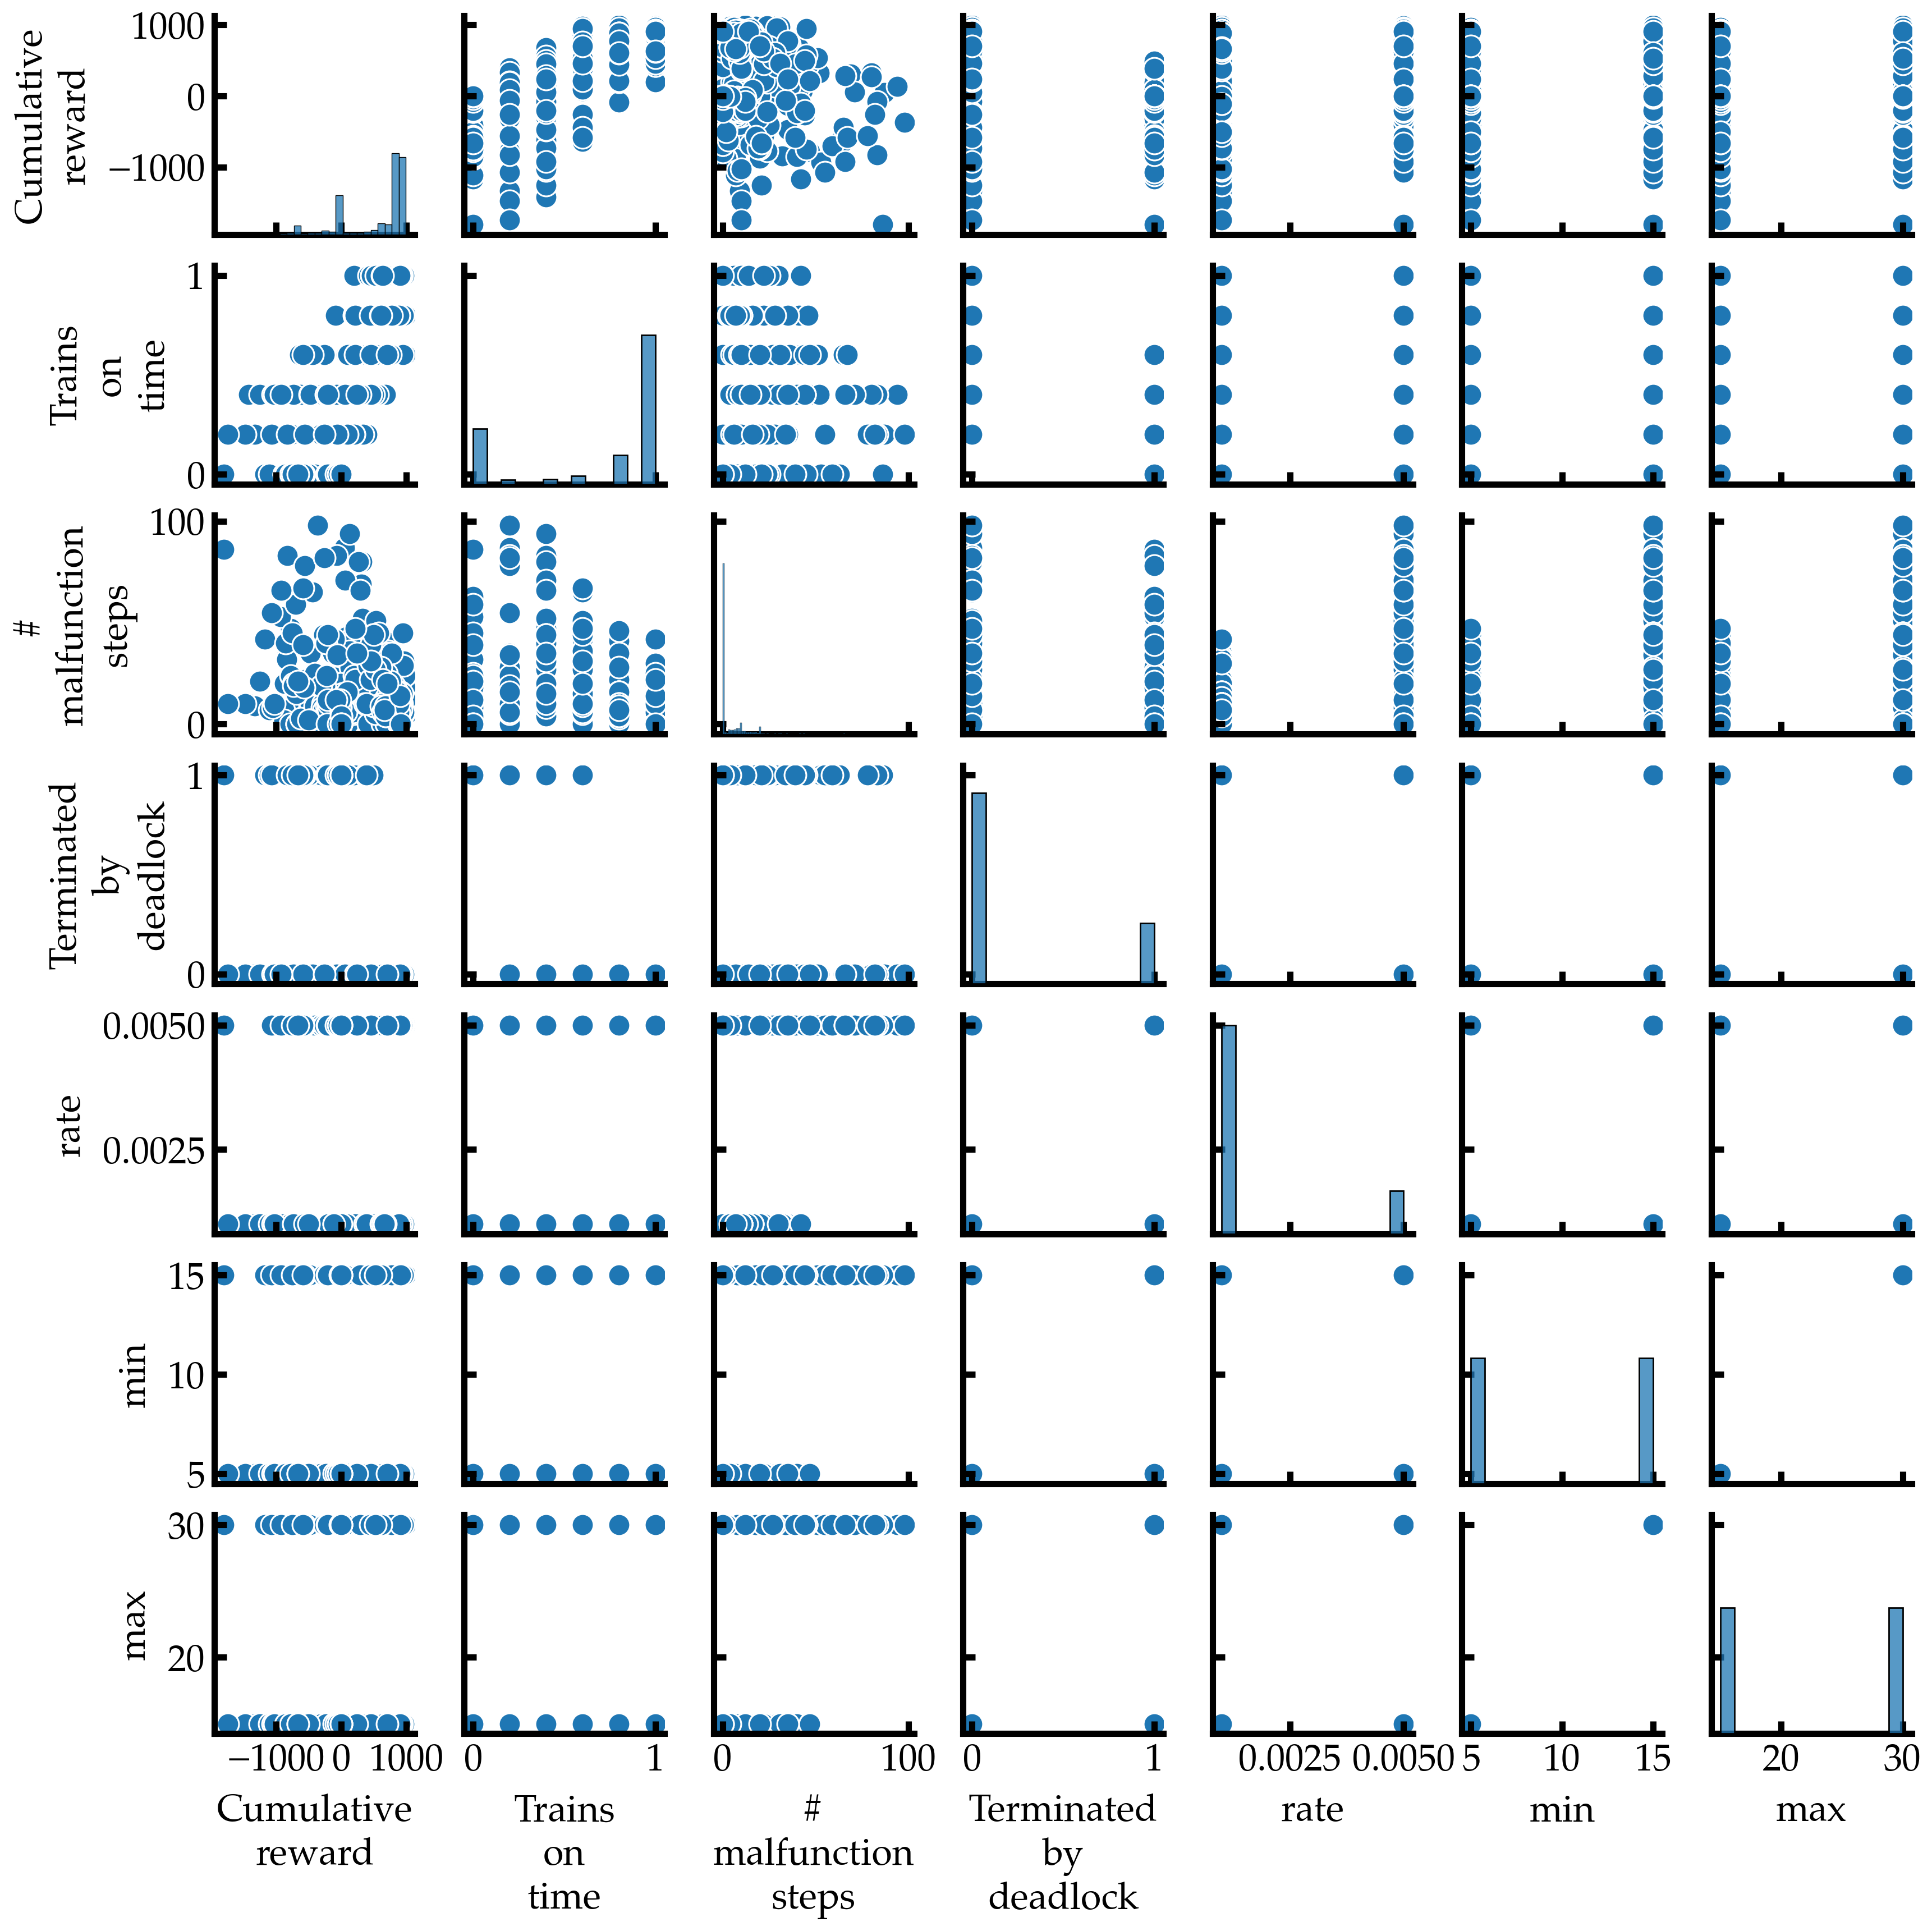

In [ ]:
data_pairplot = data_last_episode[[
    'Cumulative reward', 'Trains on time', '# malfunction steps',
    'Terminated by deadlock', 'rate', 'min', 'max'
]]
data_pairplot.columns = [c.replace(' ', '\n') for c in data_pairplot.columns]
sns.pairplot(data_pairplot)